<a href="https://colab.research.google.com/github/SrMouraSilva/Modelagem-matematica-trabalho-final/blob/main/6_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Programação simbólica
from sympy import *
from sympy.plotting import plot, plot3d
 
# Exibir símbolos nos plots
from google.colab.output._publish import javascript
url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/3.1.2/latest.js?config=default"
 
javascript(url=url)
from IPython.display import Math
 
# Manipulação dos dados
import numpy as np
import pandas as pd
 
# Gráficos
import matplotlib as mpl
import matplotlib.pyplot as plt
 
import seaborn as sns
sns.set_theme()
 
mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

## Questão 6.11

Reconsider the predator–prey model of Exercise 7 in Chapter 4.

Relembrando o exercício 4.7
> **Exercice 4.7** One of the favorite foods of the blue whale is called krill. These tiny shrimp–like creatures are devoured in massive amounts to provide the principal food source for the huge whales. The maximum sustainable population for krill is 500 tons/acre. In the absence of predators, in uncrowded conditions, the krill population grows at a rate of 25\% per year. The presence of 500 tons/acre of krill increases blue whale population growth rate by 2\% per year, and the presence of 150,000 blue whales decreases krill growth rate by 10\% per year.
>
> a) Determine whether the whales and the krill can coexist in equilibrium. Use the five-step method, and model as a dynamical system in steady state.
>
> b) Draw the vector field for this problem. Classify each equilibrium point in the state space as stable or unstable.
>
> c) Describe what happens to the two populations over time. Assume that we start off with 5,000 blue whales and 750 tons/acre of krill.
>
> d) How sensitive are your conclusions in part (c) to the assumption of a 25\% growth rate per year for krill?

### a) Determine by simulation the equilibrium levels for whales and krill. Use the simple simulation technique discussed in Section 6.2. Begin at several different initial conditions and run the simulation until both population levels have settled down into steady state.

Temos as seguintes equações para o modelo

In [ ]:
def equacoes(x1, x2):
    return (
        0.05*x1*(1-x1/150_000)+0.02/500*x1*x2,
        0.25*x2*(1-x2/500)-0.10/150_000*x1*x2,
    )

x1, x2 = var('x1 x2', real=True)

dFdx1, dFdx2 = equacoes(x1, x2)

Math(f"""
\\begin{{aligned}}
\\frac{{dx_1}}{{dt}} &= {latex(dFdx1)} \\\\
\\frac{{dx_2}}{{dt}} &= {latex(dFdx2)} \\\\
\\end{{aligned}}
""")

<IPython.core.display.Math object>

Pela técnica de simulação da Seção 6.2, uma $i$-ésima variável $x_{i,{t+1}}$ no tempo $t+1$ assume o valor de $x_{i,{t}} + f_{i}(\boldsymbol{x})$:
\begin{aligned}
x_{i,{k+1}} = x_{i,{k}} + f_{i}(\boldsymbol{x}_t),
\end{aligned}
sendo
 * $x_{i,{t}}$: $i$-ésima variável, no tempo anterior a $t+1$, ou seja, no tempo $t$;
 * $f_{i}(\boldsymbol{x}_t)$: $i$-ésima função, cujo a entrada corresponde a todas as variáveis no tempo $t$.
 
Nesta questão, temos as seguintes correspondências:
* $x_{1, t}$: população de baleias no $t$-ésimo ano;
* $x_{2, t}$: população de krill no $t$-ésimo ano;
* $f_i(\boldsymbol{x}_t) = \frac{dx_i}{dt}$.

In [ ]:
def Simulacao(variaveis, valores_iniciais, funcoes, numero_iteracoes, eta=1e-4):
    num_variaveis = len(variaveis)
    x_ = np.zeros((num_variaveis, numero_iteracoes+1))
    x_[:, 0] = valores_iniciais

    estabilizou = np.zeros(num_variaveis, dtype=bool)

    for k in range(numero_iteracoes):
        x_k = x_[:, [k]]

        valores = {k: v for k, v in zip(variaveis, x_k.flatten())}
        for i, (variavel, funcao) in enumerate(zip(variaveis, funcoes)):
            x_i = valores[variavel]
            x_i_next = x_i + N(funcao.subs(valores))
            x_[i, k+1] = x_i_next

            estabilizou[i] = abs(x_i - x_i_next) < eta

        if all(estabilizou):
            break

    return pd.DataFrame(x_.T[:k+2], columns=[str(v) for v in variaveis])

Executemos 100 simulações, respeitando os seguintes intervalos
* $x_{1,t=0} \in [0, 200{,}000]$;
* $x_{2,t=0} \in [0, 700]$;

com $t=0$ correspondendo a população inicial das espécies.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


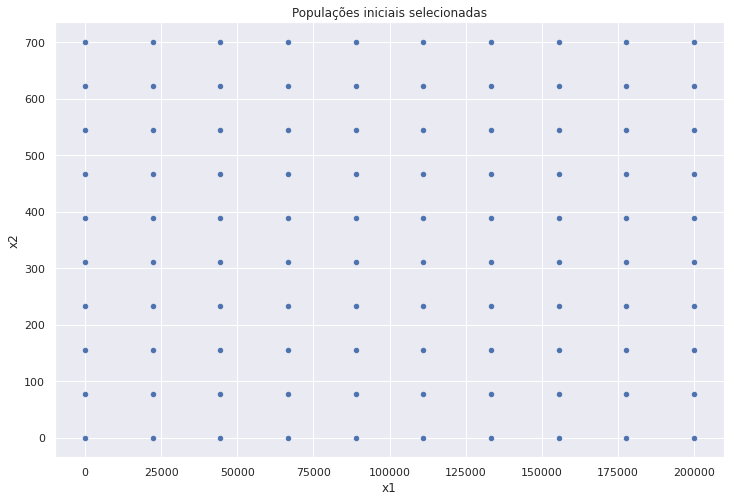

In [ ]:
# Gerar os intervalos
populacoes_iniciais = np.meshgrid(
    np.linspace(0, 200_000, 10),
    np.linspace(0, 700, 10)
)
# Reorganizar em pares
populacoes_iniciais = list(zip(
    populacoes_iniciais[0].flatten(),
    populacoes_iniciais[1].flatten()
))

pd.DataFrame(populacoes_iniciais, columns=('x1', 'x2')).plot.scatter(x='x1', y='x2', figsize=(12, 8), title="Populações iniciais selecionadas")

In [ ]:
simulacoes_a = [
    Simulacao(
        variaveis=(x1, x2),
        valores_iniciais=populacao_inicial,
        funcoes=(dFdx1, dFdx2),
        numero_iteracoes=1000
    )
    for populacao_inicial in populacoes_iniciais
]

O critério de parada utilizado para as simulações foi o seguinte:
* Pare se $|x_{i,t} - x_{i,t+1}| < 1\cdot10^{-4} ~\forall~ x_{i,t} \in \boldsymbol{x}_t, x_{i,t+1} \in \boldsymbol{x}_{t+1}$;
* Ou se $t=1000+1$.


Pegando os valores de $x_1$ e $x_2$ no final da simulação, temos os pontos de estabilidade. A seguir, são os pontos de estabilidade após arredondar a terceira casa decimal e remover as duplicações. Note que alguns pontos são bastante próximos, trataremos no próximo passo.

In [ ]:
arredondamento = 3

pontos_estaveis_a = pd.DataFrame([s.iloc[-1] for s in simulacoes_a])
pontos_estaveis_a['x1'] = pontos_estaveis_a.x1.round(arredondamento)
pontos_estaveis_a['x2'] = pontos_estaveis_a.x2.round(arredondamento)
pontos_estaveis_a.drop_duplicates()

,x1,x2
1,0.000,0.000
391,149999.998,0.000
290,150000.002,0.000
58,0.000,500.000
242,181034.482,258.621
178,181034.484,258.621
121,181034.495,258.621


Desconsiderando as casas decimais, teremos 4 soluções:

In [ ]:
arredondamento = 0

pontos_estaveis_a = pd.DataFrame([s.iloc[-1] for s in simulacoes_a])
pontos_estaveis_a['x1'] = pontos_estaveis_a.x1.round(arredondamento)
pontos_estaveis_a['x2'] = pontos_estaveis_a.x2.round(arredondamento)
pontos_estaveis_a.drop_duplicates()

,x1,x2
1,0.0,0.0
391,150000.0,0.0
58,0.0,500.0
242,181034.0,259.0


Comparando com as soluções analíticas encontradas no item a da questão 7 do capítulo 4 da lista 3, vemos que a aproximação é satisfatória.

**Soluções obtidas analiticamente**
* Ponto de equilíbrio 1: $(0, 0)$;
* Ponto de equilíbrio 2: $(0, 500)$;
* Ponto de equilíbrio 3: $(150{,}000, 0)$;
* Ponto de equilíbrio 4: $(\frac{5{,}250{,}000}{29}, \frac{7{,}500}{29})$.

Agora, apresentemos o comportamento das simulações sobre o campo vetorial. Os 4 pontos de equilíbrio localizados nas simulações correspondem as bolinhas.

Observe que o ponto de equilíbrio $(0, 0)$ só pôde ser obtida, quando a população inicial de ambas as espécies era zerado. Já os pontos de equilíbrio $(0, 500)$ e $(150{,}000, 0)$ só são obtidos, quando a população inicial de uma das espécies é zero enquanto que a outra cresce até o tamanho populacional máximo. Por fim, o ponto de equilíbrio $\left(\frac{5{,}250{,}000}{29}, \frac{7{,}500}{29}\right)$ no caso contrário corresponde ao ponto de equilíbrio correspondente a maioria das simulações.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


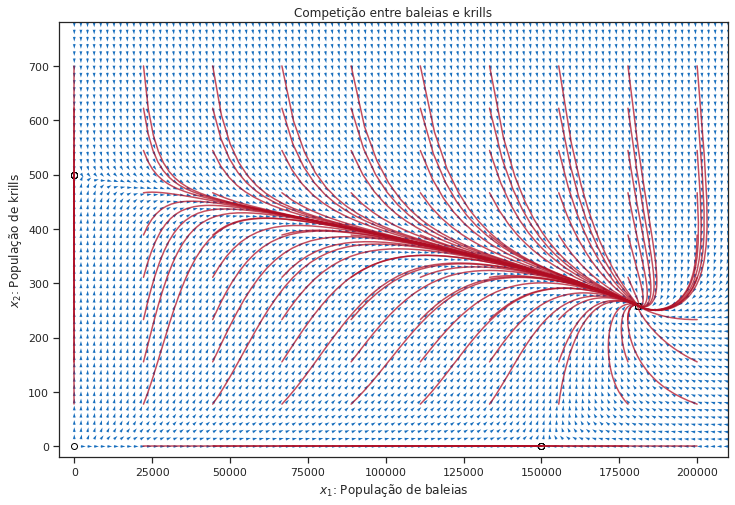

In [ ]:
def campo_vetorial(plots, cores, xlim, ylim, plot_campo_vetorial=True, legenda=None, solucoes=None):
    fig = plt.figure(figsize=(12, 8))

    if plot_campo_vetorial:
        sns.set_style("ticks")
        x1graf, x2graf = np.meshgrid(np.linspace(0, xlim[1], 100), np.linspace(0, ylim[1], 60))
        f1, f2 = equacoes(x1graf, x2graf)
        normalizador = np.sqrt(f1**2+f2**2)
        plt.quiver(x1graf, x2graf, f1/normalizador, f2/normalizador, color='#156dbd', angles='xy', figure=fig)

    ax = plt.axes()
    ax.set_title("Competição entre baleias e krills")
    ax.set_xlabel('$x_1$: População de baleias')
    ax.set_ylabel('$x_2$: População de krills')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    if solucoes is not None:
        plt.scatter(solucoes[0], solucoes[1], marker='o', edgecolors='black', color='w')
    
    for plot, cor in zip(plots, cores):
        ax.plot(*plot, color=cor,)

    if legenda is not None:
        plt.legend(legenda)

    plt.show();
    sns.set_theme()


campo_vetorial(
    [[s.x1, s.x2] for s in simulacoes_a],
    xlim=[-5_000, 200_000*1.05],
    ylim=[-20, 780],
    cores=['#b00d23bb']*100,
    solucoes=[pontos_estaveis_a.x1, pontos_estaveis_a.x2],
    #plot_campo_vetorial=False
)

### b) Suppose that after both population levels have settled down into steady state, an ecological disaster kills off $20\%$ of the whales and $80\%$ of the krill. Describe what happens to the two species, and how long it takes.

Pelo enunciado, presume-se que o item se refira ao ponto de estabilidade em que há coexistência. Executando uma simulação neste cenário, temos

In [ ]:
simulacao_b = Simulacao(
    variaveis=(x1, x2),
    valores_iniciais=(5_250_000/29 * .8, 7_500/29 * .2),
    funcoes=(dFdx1, dFdx2),
    numero_iteracoes=1000
)

print("População estável definida pela simulação")
simulacao_b[-1:]

População estável definida pela simulação


,x1,x2
210,181034.481899,258.620694


No ano 210, as duas espécies continuarão coexistindo e voltarão ao ponto de estabilidade ($\dfrac{5{,}250,000}{29}$, $\dfrac{7{,}500}{29}$) mesmo tendo acontecido um desastre ecológico que  matou $20\%$ das baleias e $80\%$ do krill no ano 0. No primeiro gráfico, podemos ver o comportamento das duas populações ao longo do tempo, sendo a linha que representa a população de baleias ($x_1$) ao longo do tempo está colorida de azul e a linha que representa a população de krill ($x_2$) está colorida de laranja. Já no segundo gráfico, podemos ver o comportamento somente da população de krill ao longo do tempo, sendo a linha que representa a população de krill ($x_2$) ao longo do tempo está colorida de azul.

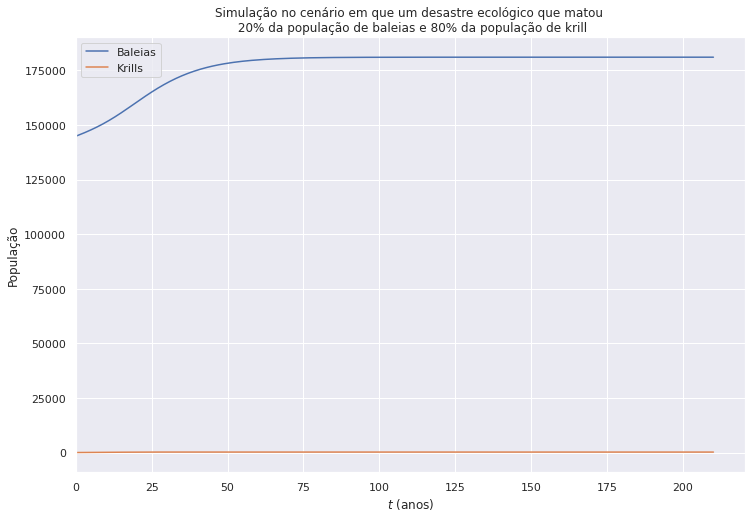

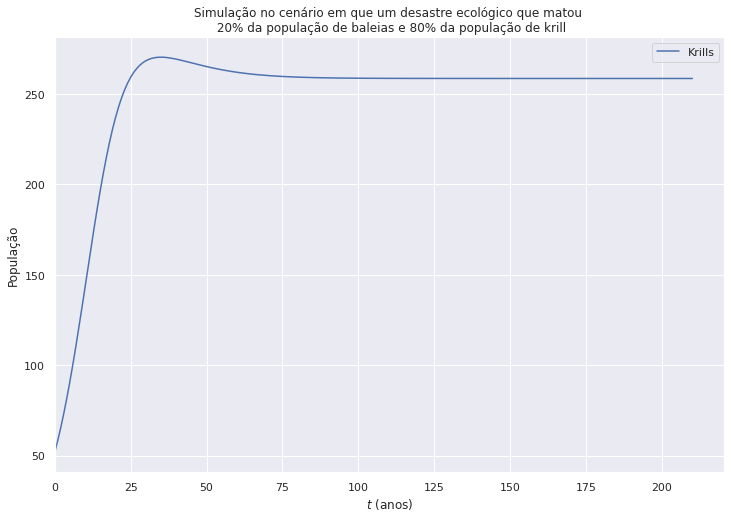

In [ ]:
ax = simulacao_b.plot(xlabel='$t$ (anos)', ylabel='População', title=f'Simulação no cenário em que um desastre ecológico que matou \n 20% da população de baleias e 80% da população de krill', figsize=(12, 8))
ax.set_xlim(left=0);
plt.legend(['Baleias', 'Krills']);
plt.show()

ax = simulacao_b.x2.plot(xlabel='$t$ (anos)', ylabel='População', title=f'Simulação no cenário em que um desastre ecológico que matou \n 20% da população de baleias e 80% da população de krill', figsize=(12, 8))
ax.set_xlim(left=0);
plt.legend(['Krills']);

Vejamos o comportamento da simulação por meio de um gráfico sobre um campo vetorial (setas azuis). O gráfico seguinte apresenta a simulação (linha vermelha) em que ocorre o retorno das duas populações ao ponto de estabilidade ($\dfrac{5{,}250{,}000}{29}$ baleias, $\dfrac{7{,}500}{29}$ krill) no qual a coexistência entre as duas espécies existe. Vale ressaltar que as 4 bolinhas correspondem aos quatro pontos de equilíbrio encontrados no item $a)$ desta questão.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


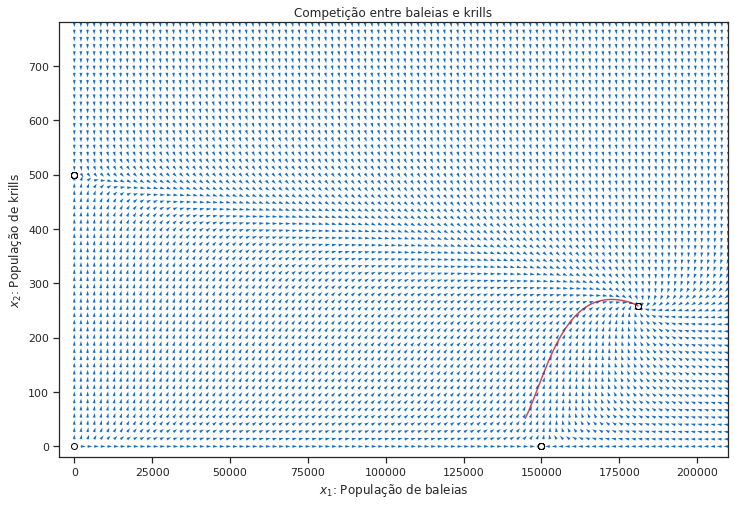

In [ ]:
campo_vetorial(
    [[simulacao_b.x1, simulacao_b.x2]],
    xlim=[-5_000, 200_000*1.05],
    ylim=[-20, 780],
    cores=['#b00d23bb']*100,
    solucoes=[pontos_estaveis_a.x1, pontos_estaveis_a.x2],
    #plot_campo_vetorial=False
)

### c) Suppose that harvesting has depleted the whales to $5\%$ of their equilibrium population level, while krill remain at about the same level. Describe what happens once harvesting is stopped. How long does it take for the whales to grow back? What happens to the krill population?

Pelo enunciado, presume-se que o item se refira ao ponto de estabilidade em que há coexistência. Executando uma simulação neste cenário, temos

In [ ]:
simulacao_c = Simulacao(
    variaveis=(x1, x2),
    valores_iniciais=(5_250_000/29 * .05, 7_500/29),
    funcoes=(dFdx1, dFdx2),
    numero_iteracoes=1000
)

print("População estável definida pela simulação")
simulacao_c[-1:]

População estável definida pela simulação


,x1,x2
255,181034.481873,258.620694


No ano 255, as duas espécies continuarão coexistindo e voltarão ao ponto de estabilidade $(\frac{5{,}250{,}000}{29}, \frac{7{,}500}{29})$ mesmo após ocorrer uma caça que resultou na morte de 95% das baleias. No primeiro gráfico, podemos ver o comportamento das duas populações ao longo do tempo, sendo a linha que representa a população de baleias ($x_1$) ao longo do tempo está colorida de azul e a linha que representa a população de krill ($x_2$) está colorida de laranja. Já no segundo gráfico, podemos ver o comportamento somente da população de krill ao longo do tempo, sendo a linha que representa a população de krill ($x_2$) ao longo do tempo está colorida de azul.

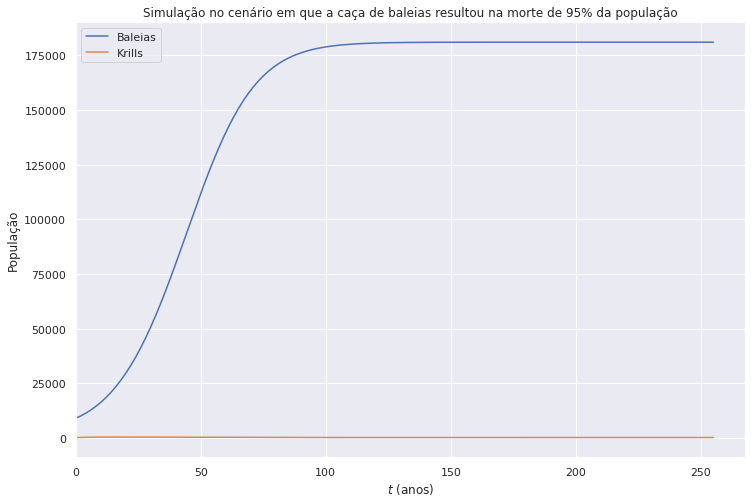

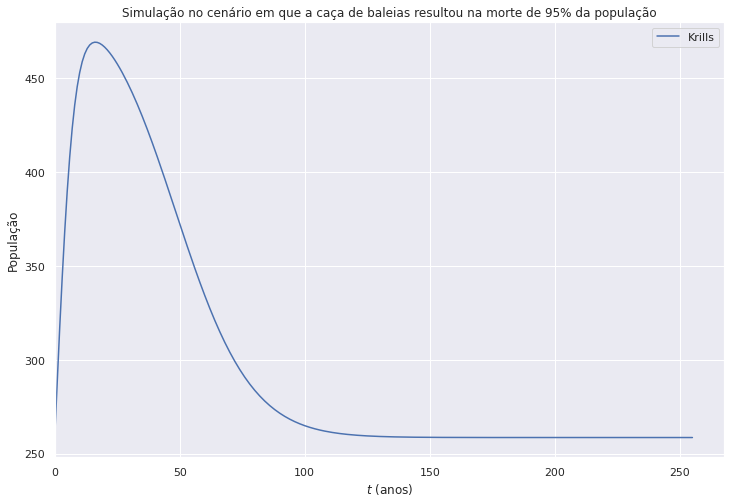

In [ ]:
ax = simulacao_c.plot(xlabel='$t$ (anos)', ylabel='População', title=f'Simulação no cenário em que a caça de baleias resultou na morte de 95% da população', figsize=(12, 8))
ax.set_xlim(left=0);
plt.legend(['Baleias', 'Krills']);
plt.show()

ax = simulacao_c.x2.plot(xlabel='$t$ (anos)', ylabel='População', title=f'Simulação no cenário em que a caça de baleias resultou na morte de 95% da população', figsize=(12, 8))
ax.set_xlim(left=0);
plt.legend(['Krills']);

Vejamos o comportamento da simulação por meio de um gráfico sobre um campo vetorial (setas azuis). O gráfico seguinte apresenta a simulação (linha vermelha) em que ocorre o retorno das duas populações ao ponto de estabilidade ($\dfrac{5{,}250{,}000}{29}$ baleias, $\dfrac{7{,}500}{29}$ krill) no qual a coexistência entre as duas espécies existe. Vale ressaltar que as 4 bolinhas correspondem aos quatro pontos de equilíbrio encontrados no item $a)$ desta questão.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


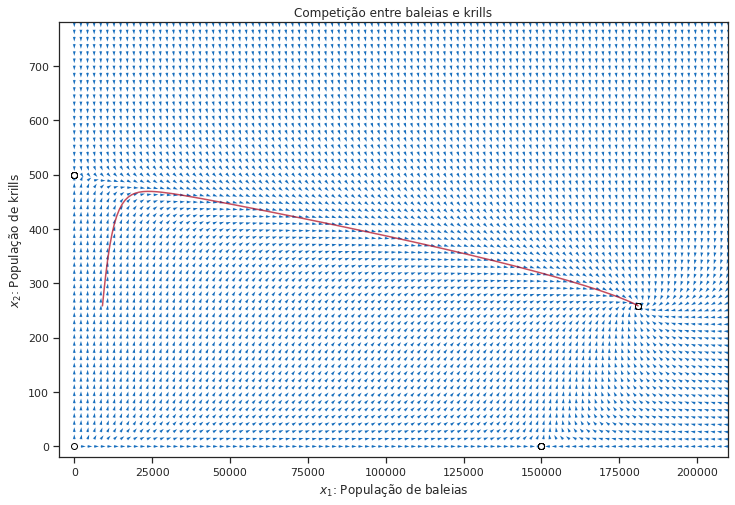

In [ ]:
campo_vetorial(
    [[simulacao_c.x1, simulacao_c.x2]],
    xlim=[-5_000, 200_000*1.05],
    ylim=[-20, 780],
    cores=['#b00d23bb']*100,
    solucoes=[pontos_estaveis_a.x1, pontos_estaveis_a.x2],
    #plot_campo_vetorial=False
)

### d) Examine the sensitivity of your results in part (c) to the assumption that $5\%$ of the whales remain. Simulate each of the cases where $1$, $3$, $7$, or $10\%$ remain, and tabulate your results. How sensitive is the time it takes for the whales to grow back to the extent to which the population is depleted?

Realizemos as simulações para as proporções de baleias sobreviventes à caça:

In [ ]:
proporcao_baleaias_restantes = [.01, .03, 0.07, .1]

simulacoes_d = [
    Simulacao(
        variaveis=(x1, x2),
        valores_iniciais=(5_250_000/29 * proporcao, 7_500/29),
        funcoes=(dFdx1, dFdx2),
        numero_iteracoes=1000
    )
    for proporcao in proporcao_baleaias_restantes
]

Pela tabela abaixo, podemos observar que quando as taxas de população restante de baleias estão no intervalo $[0.01, 0.1]$, esta espécie coexistirá com a população de krill. Nestes cenários, a medida que a taxa de população restante de baleias se aproxima de $0.1$, em menos tempo as duas populações de espécies se aproximarão do ponto de estabilidade ($\dfrac{5,250,000}{29}$ baleias, $\dfrac{7,500}{29}$ krill).
 

In [ ]:
resultados_d = []

for s, p in zip(simulacoes_d, proporcao_baleaias_restantes):
    resultado = s[-1:].copy()
    resultado['Proporção de baleias restantes'] = p
    resultado['Tempo necessário para estabilizar (em anos)'] = resultado.index
    resultados_d.append(resultado)
    

pd.concat(resultados_d)

,x1,x2,Proporção de baleias restantes,Tempo necessário para estabilizar (em anos)
279,181034.481844,258.620694,0.01,279
263,181034.481890,258.620694,0.03,263
250,181034.481895,258.620694,0.07,250
244,181034.481867,258.620694,0.10,244


A legenda das colunas da tabela acima indica as populações finais das variáveis $x_1$ e $x_2$ seguidos da taxa de população restante de $x_1$ e do tempo necessário para estabilizar no ponto de equilíbrio de coexistência.

Agora, vejamos o comportamento das simulações por meio de um gráfico sobre um campo vetorial (setas azuis). O gráfico seguinte apresenta as simulações em que ocorre a coexistência. 

A legenda das colunas do gráfico abaixo indica a taxa de população restante de $x_1$.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


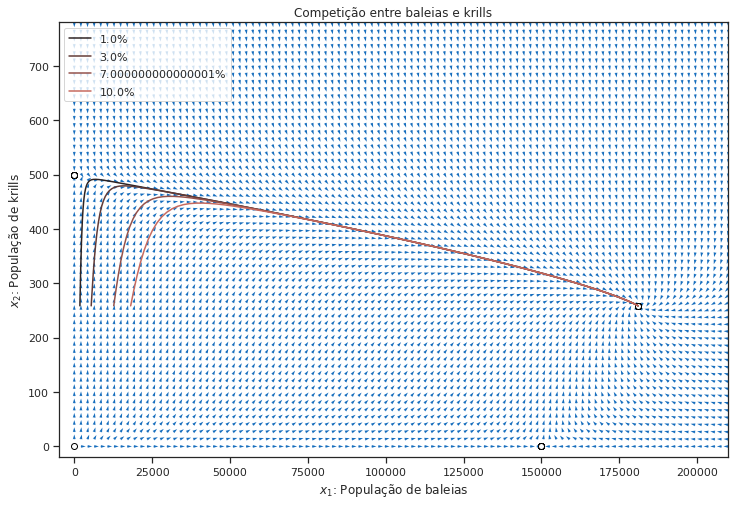

In [ ]:
campo_vetorial(
    [[s.x1, s.x2] for s in simulacoes_d],
    xlim=[-5_000, 200_000*1.05],
    ylim=[-20, 780],
    cores=sns.color_palette("dark:salmon_r", 5)[::-1],
    solucoes=[pontos_estaveis_a.x1, pontos_estaveis_a.x2],
    #plot_campo_vetorial=False,
    legenda=[f'${p*100}\%$' for p in proporcao_baleaias_restantes]
)

No gráfico seguinte, podemos ver o comportamento das duas populações ao longo do tempo. Para as simulações solicitadas, sempre haverá coexistência entre as espécies. As linhas representando a população de baleias ($x_1$) ao longo do tempo estão coloridas por tonalidades de azul e as linhas representando a população de krill ($x_2$) estão coloridas por tonalidades de vermelho.

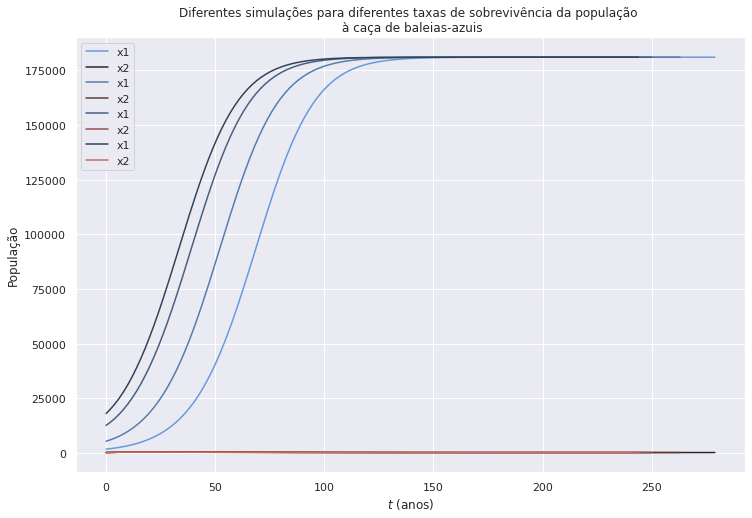

In [ ]:
ax = pd.concat(simulacoes_d, axis=1).plot(
    xlabel='$t$ (anos)',
    ylabel='População',
    title=f'Diferentes simulações para diferentes taxas de sobrevivência da população \n à caça de baleias-azuis',
    color=np.array(
        list(zip(
            sns.dark_palette("#69d", 5, reverse=True),
            sns.color_palette("dark:salmon_r", 5)[::-1]
        ))
    ).reshape((-1, 3)),
    figsize=(12, 8)
)

A conclusão sobre a sensibilidade de nossos resultados ao parâmetro que mede a taxa de população restante de baleias é que:

* ao variar a taxa de população restante de baleias entre $1\%$ a $10\%$, percebemos que o modelo tende a ir mais rápido para o ponto de estabilidade no qual há coexistência entre as espécies.
